In [1]:
import os.path as osp
import random
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [2]:
def make_datapath_list(rootpath):
    imgpath_template = osp.join(rootpath, "JPEGImages", "%s.jpg")
    annopath_template = osp.join(rootpath, "Annotations", "%s.xml")

    train_id_names = osp.join(rootpath + "ImageSets/Main/train.txt")
    val_id_names = osp.join(rootpath + "ImageSets/Main/val.txt")
    
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [3]:
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

print(train_img_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


In [4]:
"""
ANNOTATION.xml sample format

<annotation>
	<folder>VOC2012</folder>
	<filename>2007_000027.jpg</filename>
	<source>
		<database>The VOC2007 Database</database>
		<annotation>PASCAL VOC2007</annotation>
		<image>flickr</image>
	</source>
	<size>
		<width>486</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>person</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>174</xmin>
			<ymin>101</ymin>
			<xmax>349</xmax>
			<ymax>351</ymax>
		</bndbox>
		<part>
			<name>head</name>
			<bndbox>
				<xmin>169</xmin>
				<ymin>104</ymin>
				<xmax>209</xmax>
				<ymax>146</ymax>
			</bndbox>
		</part>
		<part>
			<name>hand</name>
			<bndbox>
				<xmin>278</xmin>
				<ymin>210</ymin>
				<xmax>297</xmax>
				<ymax>233</ymax>
			</bndbox>
		</part>
		<part>
			<name>foot</name>
			<bndbox>
				<xmin>273</xmin>
				<ymin>333</ymin>
				<xmax>297</xmax>
				<ymax>354</ymax>
			</bndbox>
		</part>
		<part>
			<name>foot</name>
			<bndbox>
				<xmin>319</xmin>
				<ymin>307</ymin>
				<xmax>340</xmax>
				<ymax>326</ymax>
			</bndbox>
		</part>
	</object>
</annotation>
"""

'\nANNOTATION.xml sample format\n\n<annotation>\n\t<folder>VOC2012</folder>\n\t<filename>2007_000027.jpg</filename>\n\t<source>\n\t\t<database>The VOC2007 Database</database>\n\t\t<annotation>PASCAL VOC2007</annotation>\n\t\t<image>flickr</image>\n\t</source>\n\t<size>\n\t\t<width>486</width>\n\t\t<height>500</height>\n\t\t<depth>3</depth>\n\t</size>\n\t<segmented>0</segmented>\n\t<object>\n\t\t<name>person</name>\n\t\t<pose>Unspecified</pose>\n\t\t<truncated>0</truncated>\n\t\t<difficult>0</difficult>\n\t\t<bndbox>\n\t\t\t<xmin>174</xmin>\n\t\t\t<ymin>101</ymin>\n\t\t\t<xmax>349</xmax>\n\t\t\t<ymax>351</ymax>\n\t\t</bndbox>\n\t\t<part>\n\t\t\t<name>head</name>\n\t\t\t<bndbox>\n\t\t\t\t<xmin>169</xmin>\n\t\t\t\t<ymin>104</ymin>\n\t\t\t\t<xmax>209</xmax>\n\t\t\t\t<ymax>146</ymax>\n\t\t\t</bndbox>\n\t\t</part>\n\t\t<part>\n\t\t\t<name>hand</name>\n\t\t\t<bndbox>\n\t\t\t\t<xmin>278</xmin>\n\t\t\t\t<ymin>210</ymin>\n\t\t\t\t<xmax>297</xmax>\n\t\t\t\t<ymax>233</ymax>\n\t\t\t</bndbox>\n\t\t<

In [5]:
class Anno_xml2list():
    def __init__(self, classes):
        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        in:
            xml_path: str, xml 파일경로
            width, height: int
            ret:[[xmin, ymin, xmax, ymax, label_idx], ...], Annotation Data List
        """
        #모든 물체의 annotation 저장
        ret = []

        xml = ET.parse(xml_path).getroot()

        #물체 개수(object) iterate
        for obj in xml.iter("object"):
            name = ""
            difficult = int(obj.find("difficult").text)
            if difficult == 1:
                continue
            
            #bounding box for each object
            bndbox = []
            name = obj.find("name").text.lower().strip() #공백제거
            bbox = obj.find("bndbox")

            pts = ["xmin", "ymin", "xmax", "ymax"]
            for pt in pts:
                cur_pixel = int(bbox.find(pt).text) - 1
                #Normalize
                if pt == "xmin" or pt == "xmax":
                    cur_pixel /= width
                else:
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            label_idx = self.classes.index(name)
            bndbox.append(label_idx)
            ret.append(bndbox)
        print(f"{xml_path}")
        return np.array(ret)

In [6]:
voc_classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

transform_anno = Anno_xml2list(voc_classes)

ind = random.randint(0, 30)
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)
height, width, channels = img.shape

transform_anno(val_anno_list[ind], width, height)

./data/VOCdevkit/VOC2012/Annotations/2008_000078.xml


array([[ 0.03282276,  0.        ,  0.95185996,  0.998     , 11.        ]])

In [7]:
import sys
module_path = "/Users/wonjunchoi/Documents/SelfStudy/SSD/utils"
sys.path.append(module_path)

from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

class DataTransform():
    def __init__(self, input_size, color_mean):
        self.data_transform = {
            "train": Compose([
                ConvertFromInts(),
                ToAbsoluteCoords(),
                PhotometricDistort(),
                Expand(color_mean),
                RandomSampleCrop(),
                RandomMirror(),
                ToPercentCoords(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ]),
            "val": Compose([
                ConvertFromInts(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        return self.data_transform[phase](img, boxes, labels)

./data/VOCdevkit/VOC2012/Annotations/2008_000008.xml


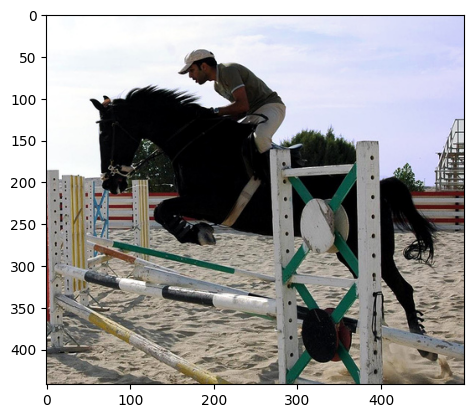

In [8]:
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path) #h, w, c
height, width, channels = img.shape
transform_anno = Anno_xml2list(voc_classes)
anno_lsit = transform_anno(train_anno_list[0], width, height)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


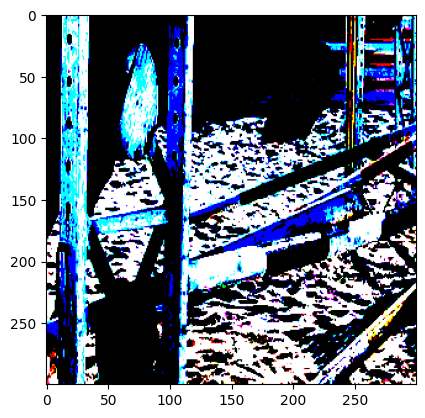

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


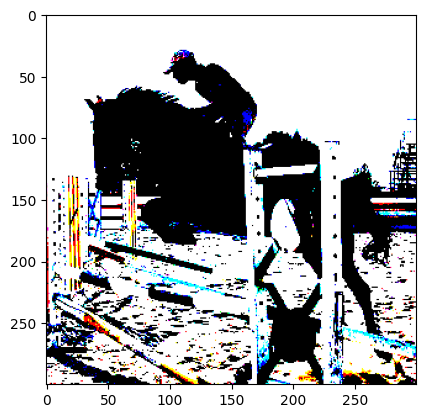

In [9]:
color_mean = (104, 117, 123)
input_size = 300
transform = DataTransform(input_size, color_mean)

phase = "train"
img_transformed, boxes, labels = transform(img, phase, anno_lsit[:, :4], anno_lsit[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

phase = "val"
img_transformed, boxes, labels = transform(img, phase, anno_lsit[:, :4], anno_lsit[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
#dataset 작성
class VOCDataset(data.Dataset):
    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        im, gt, h, w = self.pull_item(index)
        return im, gt
    

In [11]:
criterion = nn.CrossEntropyLoss()

NameError: name 'nn' is not defined